In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [3]:
transform = transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])
trainset = torchvision.datasets.CIFAR10(root='./data/', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data/',train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100.0%

Extracting ./data/cifar-10-python.tar.gz to ./data/
Files already downloaded and verified


In [4]:
import matplotlib.pyplot as plt
import numpy as np

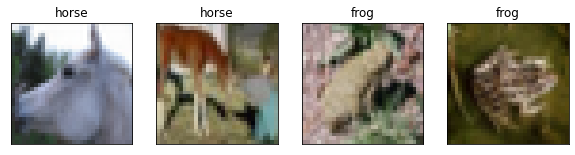

In [26]:
def convert_to_imshow_format(image):
    image = image/2 + 0.5
    image = image.numpy()
    return image.transpose(1,2,0)

dataiter = iter(trainloader)
images, labels = dataiter.next()

fig, axes = plt.subplots(1, len(images), figsize=(10,2.5))
for idx, image in enumerate(images):
    axes[idx].imshow(convert_to_imshow_format(image))
    axes[idx].set_title(classes[labels[idx]])
    axes[idx].set_xticks([])
    axes[idx].set_yticks([])

In [27]:
import torch.nn as nn
import torch.nn.functional as F

In [41]:
labels

tensor([6, 1, 1, 7])

In [34]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3,6,5)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(6,16,5)
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84,10)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1,16*5*5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()

In [35]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [54]:
import os

model_directory_path = './data/'
model_path = model_directory_path + 'cifar-10-cnn-model.pt'

if not os.path.exists(model_directory_path):
    os.makedirs(model_directory_path)

if os.path.isfile(model_path):
    net.load_state_dict(torch.load(model_path))
    print('Loaded model from disk.')
else:
    for epoch in range(2):
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            if i % 2000 == 1999:
                print('[%d, %5d] loss: %.3f' % (epoch +1, i+1, running_loss/2000))
                running_loss = 0.0
    print('Finished training.')
    torch.save(net.state_dict(), model_path)
    print('Saved model to disk.')

Loaded model from disk.


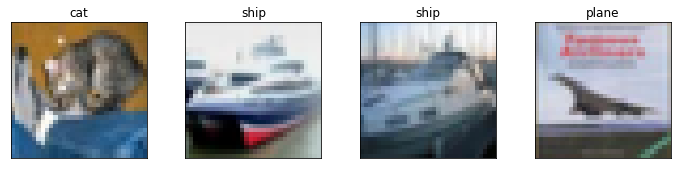

In [48]:
dataiter  = iter(testloader)
images, labels = dataiter.next()

fig, axes = plt.subplots(1, len(images), figsize=(12, 2.5))
for idx, image in enumerate(images):
    axes[idx].imshow(convert_to_imshow_format(image))
    axes[idx].set_title(classes[labels[idx]])
    axes[idx].set_xticks([])
    axes[idx].set_yticks([])

In [50]:
outputs = net(images)
outputs

tensor([[-1.9361, -1.5934, -0.0354,  3.0056, -0.0911,  1.8831,  1.3604, -0.3795,
         -0.9320, -1.7139],
        [ 4.8430,  7.5231, -3.8247, -4.1549, -3.4318, -5.4151, -4.8463, -4.7448,
          8.7149,  5.3917],
        [ 1.9698,  3.0046, -1.1711, -1.3073, -1.7008, -2.1639, -2.1052, -1.7117,
          3.4153,  2.2849],
        [ 2.8823,  1.3605,  0.1148, -1.4624,  0.2745, -2.0144, -1.8900, -1.0119,
          1.9628,  0.8208]], grad_fn=<AddmmBackward>)

In [51]:
sm = nn.Softmax(dim=1)
sm_outputs = sm(outputs)
sm_outputs

tensor([[4.2242e-03, 5.9506e-03, 2.8261e-02, 5.9139e-01, 2.6731e-02, 1.9247e-01,
         1.1413e-01, 2.0033e-02, 1.1529e-02, 5.2751e-03],
        [1.5302e-02, 2.2321e-01, 2.6327e-06, 1.8924e-06, 3.8999e-06, 5.3668e-07,
         9.4783e-07, 1.0490e-06, 7.3499e-01, 2.6488e-02],
        [1.0423e-01, 2.9338e-01, 4.5074e-03, 3.9335e-03, 2.6539e-03, 1.6702e-03,
         1.7712e-03, 2.6252e-03, 4.4238e-01, 1.4284e-01],
        [5.1811e-01, 1.1312e-01, 3.2546e-02, 6.7226e-03, 3.8183e-02, 3.8707e-03,
         4.3837e-03, 1.0549e-02, 2.0658e-01, 6.5934e-02]],
       grad_fn=<SoftmaxBackward>)

In [52]:
probs, index = torch.max(sm_outputs, dim=1)

for p, i in zip(probs, index):
    print('{0} - {1:.4f}'.format(classes[i],p))

cat - 0.5914
ship - 0.7350
ship - 0.4424
plane - 0.5181


In [56]:
total_correct = 0
total_images = 0
confusion_matrix = np.zeros([10,10], int)
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total_images += labels.size(0)
        total_correct += (predicted == labels).sum().item()
        for i, l in enumerate(labels):
            confusion_matrix[l.item(), predicted[i].item()] += 1
            
model_accuracy = total_correct /total_images * 100
print('Model accuracy on {0} test images: {1: .2f}%'.format(total_images, model_accuracy))

Model accuracy on 10000 test images:  55.55%


In [57]:
print('{0:10s} - {1}'.format('Category', 'Accuracy'))
for i, r in enumerate(confusion_matrix):
    print('{0:10s} - {1:.1f}'.format(classes[i], r[i]/np.sum(r)*100))

Category   - Accuracy
plane      - 49.2
car        - 66.2
bird       - 27.0
cat        - 31.6
deer       - 58.0
dog        - 55.2
frog       - 54.6
horse      - 71.2
ship       - 66.9
truck      - 75.6
